### 1. 라이브러리 선언 및 데이터 불러오기

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# ## 1. 데이터 불러오기

salesData = pd.read_csv("./dataset/pro_actual_sales.csv")
salesData.columns = salesData.columns.str.upper() 
salesData.head()

,REGIONSEG1,PRODUCTSEG1,PRODUCTSEG2,REGIONSEG2,REGIONSEG3,PRODUCTSEG3,YEARWEEK,YEAR,WEEK,QTY
0,A01,NaN,PG05,SALESID0001,SITEID0004,ITEM0445,201306,2013,6,5
1,A01,NaN,PG05,SALESID0001,SITEID0004,ITEM0445,201307,2013,7,8
2,A01,NaN,PG05,SALESID0001,SITEID0004,ITEM0445,201308,2013,8,7
3,A01,NaN,PG05,SALESID0001,SITEID0004,ITEM0445,201309,2013,9,1
4,A01,NaN,PG05,SALESID0001,SITEID0004,ITEM0445,201310,2013,10,1


### 2. 데이터 정제 (2년 이상 실적 자료 정제 및 53주차 제거된 풀데이터 셋)

In [4]:
# ##### 제품 별로 데이터 나누기

groupkey = ["REGIONSEG1","REGIONSEG2","REGIONSEG3","PRODUCTSEG2","PRODUCTSEG3"]
groupData = salesData.groupby(groupkey)['YEARWEEK','YEAR','WEEK','QTY']
groupData

In [5]:
groupsData = salesData.groupby(groupkey)["YEARWEEK"].agg(["count"]).reset_index()

In [6]:
groupsData = groupsData.rename(columns={"count":"KNOB"})

In [7]:
# 모든 데이터를 key(groupKey)와 data로 나누고 매칭시켜 딕셔너리로 변환할건데,  
# seq_length를 고려해서 52주차 이상의 실적이 있는 데이터만 선별하여 담는다.

In [8]:
joinData = pd.merge(left=salesData, right=groupsData,on=groupkey)

maxKnob = 104

cleansedData = joinData[joinData.KNOB >= maxKnob]

len(cleansedData.PRODUCTSEG3.drop_duplicates())

96

In [9]:
# # normalizing

# newqty=[]

# for i in range(0,len(each_data)):
#     maxval = each_data[i]["QTY"].max()
#     each_data[i]["QTY"].values.astype('float')
#     tmpqty= each_data[i]["QTY"].values #/maxval
#     newqty.append(tmpqty)
    
#     each_data[i]["NEW_QTY"]=""
#     each_data[i]["NEW_QTY"]=tmpqty

In [10]:
eachItem = cleansedData[(cleansedData.PRODUCTSEG3 =="ITEM0110") &
                        (cleansedData.REGIONSEG3 == "SITEID0004")]

In [11]:
eachItem2 = eachItem.reset_index(drop=True)

In [12]:
len(eachItem)

154

In [13]:
eachItem2.describe()

,PRODUCTSEG1,YEARWEEK,YEAR,WEEK,QTY,KNOB
count,0.0,154.000000,154.000000,154.000000,154.000000,154.0
mean,NaN,201481.818182,2014.551948,26.623377,148.123377,154.0
std,NaN,88.519593,0.943102,15.300510,179.190202,0.0
min,NaN,201331.000000,2013.000000,1.000000,8.000000,154.0
25%,NaN,201417.250000,2014.000000,13.250000,56.000000,154.0
50%,NaN,201503.500000,2015.000000,26.000000,76.500000,154.0
75%,NaN,201541.750000,2015.000000,40.000000,139.250000,154.0
max,NaN,201627.000000,2016.000000,53.000000,1147.000000,154.0


### 데이터 분리

In [25]:
targetColumns = ["QTY"]
targetData = eachItem2[targetColumns]
scaler = MinMaxScaler(feature_range=(0, 1))
qtyList = scaler.fit_transform(targetData)
qtyList

array([[0.        ],
       [0.02019315],
       [0.02194908],
       [0.01316945],
       [0.04389816],
       [0.06848112],
       [0.02546093],
       [0.02721686],
       [0.02985075],
       [0.023705  ],
       [0.02458297],
       [0.05443371],
       [0.01316945],
       [0.01931519],
       [0.28007024],
       [0.42054434],
       [0.49692713],
       [0.79543459],
       [0.39508341],
       [0.02897278],
       [0.04477612],
       [0.02546093],
       [0.023705  ],
       [0.0333626 ],
       [0.0500439 ],
       [0.04477612],
       [0.02809482],
       [0.06584723],
       [0.06057946],
       [0.08867428],
       [0.01931519],
       [0.03687445],
       [0.04389816],
       [0.01755926],
       [0.01580334],
       [0.05355575],
       [0.08691835],
       [0.06848112],
       [0.06848112],
       [0.05179982],
       [0.07901668],
       [0.09130817],
       [0.16154522],
       [0.19841967],
       [0.08604039],
       [0.2071993 ],
       [0.2572432 ],
       [0.336

In [15]:
targetColumns = ["YEARWEEK","QTY"]

targetData = eachItem2[targetColumns]

targetData = targetData.set_index("YEARWEEK")

qtyList = np.array(targetData.QTY).reshape(-1,1)

qtyList.shape

(154, 1)

In [16]:
from sklearn.preprocessing import MinMaxScaler

# 데이터 전처리 * 최소 최대값을 구해서 0~1범위로 변환
scaler = MinMaxScaler(feature_range=(0, 1))
qtyList = scaler.fit_transform(qtyList)

stdIndex = int(len(qtyList)*0.7)

stdIndex

# 데이터 분리
train = qtyList[0:stdIndex]
test = qtyList[stdIndex:]

In [17]:
dataset = train

In [18]:
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [40]:
qtyList = np.array([100,200,30,20,50,10,20,30,70]).reshape(-1,1)

In [41]:
qtyList

array([[100],
       [200],
       [ 30],
       [ 20],
       [ 50],
       [ 10],
       [ 20],
       [ 30],
       [ 70]])

In [45]:
look_back = 10

In [42]:
create_dataset(qtyList, look_back)

(array([[100, 200,  30],
        [200,  30,  20],
        [ 30,  20,  50],
        [ 20,  50,  10],
        [ 50,  10,  20],
        [ 10,  20,  30]]), array([20, 50, 10, 20, 30, 70]))

In [39]:
qtyList

[[100], [200], [30], [20], [50]]

In [33]:
x_train

array([[[0.        ],
        [0.02019315],
        [0.02194908],
        [0.01316945],
        [0.04389816],
        [0.06848112],
        [0.02546093],
        [0.02721686],
        [0.02985075],
        [0.023705  ]],

       [[0.02019315],
        [0.02194908],
        [0.01316945],
        [0.04389816],
        [0.06848112],
        [0.02546093],
        [0.02721686],
        [0.02985075],
        [0.023705  ],
        [0.02458297]],

       [[0.02194908],
        [0.01316945],
        [0.04389816],
        [0.06848112],
        [0.02546093],
        [0.02721686],
        [0.02985075],
        [0.023705  ],
        [0.02458297],
        [0.05443371]],

       [[0.01316945],
        [0.04389816],
        [0.06848112],
        [0.02546093],
        [0.02721686],
        [0.02985075],
        [0.023705  ],
        [0.02458297],
        [0.05443371],
        [0.01316945]],

       [[0.04389816],
        [0.06848112],
        [0.02546093],
        [0.02721686],
        [0.02985075],
  

In [46]:
# 데이터셋 생성
x_train, y_train = create_dataset(train, look_back)
x_test, y_test = create_dataset(test, look_back)

In [47]:
print(x_train.shape)
print(x_test.shape)

(97, 10)
(37, 10)


In [55]:
# 데이터셋 전처리
x_train = x_train.reshape( len(x_train), look_back, 1)
x_test = x_test.reshape( len(x_test), look_back, 1)

In [56]:
inputShape = x_train[0].shape

In [57]:
inputShape

(10, 1)

### 모델 생성 (DNN)

In [58]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Flatten
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
%matplotlib inline

In [59]:
model = Sequential()
model.add(Flatten(input_shape=inputShape))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='relu'))

In [60]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [61]:
hist = model.fit(x_train, y_train, epochs=50, batch_size=32, validation_data=(x_test, y_test))

Train on 97 samples, validate on 37 samples
Epoch 1/50
97/97 [==============================] - 1s 7ms/sample - loss: 0.0513 - val_loss: 0.0289
Epoch 2/50
97/97 [==============================] - 0s 253us/sample - loss: 0.0513 - val_loss: 0.0289
Epoch 3/50
97/97 [==============================] - 0s 195us/sample - loss: 0.0513 - val_loss: 0.0289
Epoch 4/50
97/97 [==============================] - 0s 206us/sample - loss: 0.0513 - val_loss: 0.0289
Epoch 5/50
97/97 [==============================] - 0s 218us/sample - loss: 0.0513 - val_loss: 0.0289
Epoch 6/50
97/97 [==============================] - 0s 236us/sample - loss: 0.0513 - val_loss: 0.0289
Epoch 7/50
97/97 [==============================] - 0s 226us/sample - loss: 0.0513 - val_loss: 0.0289
Epoch 8/50
97/97 [==============================] - 0s 175us/sample - loss: 0.0513 - val_loss: 0.0289
Epoch 9/50
97/97 [==============================] - 0s 185us/sample - loss: 0.0513 - val_loss: 0.0289
Epoch 10/50
97/97 [=====================

In [62]:
trainScore = model.evaluate(x_train, y_train, verbose=0)
model.reset_states()
print('Train Score: ', trainScore)

testScore = model.evaluate(x_test, y_test, verbose=0)
model.reset_states()
print('Test Score: ', testScore)

Train Score:  0.05132901156801231
Test Score:  0.028936740866786725


In [63]:
# model.predict(x_test[0].reshape(1, 10))

pred = pd.DataFrame(model.predict(x_test))

pd.DataFrame(scaler.inverse_transform(pred))

,0
0,8.0
1,8.0
2,8.0
3,8.0
4,8.0
5,8.0
6,8.0
7,8.0
8,8.0
9,8.0


### 모델 예측 (1 주)

In [64]:
currQty = x_test[-1:]

currQty = currQty.flatten()

len(currQty)

currQty = currQty.reshape(-1,1)

predictValue = model.predict(currQty.reshape(1,look_back,1))
predictValue

array([[0.]], dtype=float32)

In [65]:
inversePred = scaler.inverse_transform(predictValue)

### 모델 예측 (연속 주)

In [66]:
qtyIn = list(test.flatten()[-10:])

pred_count = 30 # 최대 예측 개수 정의

pred_out = []

for i in range(pred_count):
    sample_in = np.array(qtyIn)
    currQty = sample_in.reshape(-1,1)
    predValue = model.predict(currQty.reshape(1,look_back,1)).flatten()[0]
    pred_out.append(predValue)
    qtyIn.append(predValue)
    qtyIn.pop(0)

### 모델 생성 (LSTM)

In [67]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
%matplotlib inline

In [68]:
inputShape

(10, 1)

In [69]:
model = Sequential()
model.add(LSTM(32, input_shape=inputShape))
model.add(Dropout(0.3))
model.add(Dense(1))

### 모델 컴파일

In [70]:
model.compile(loss='mean_squared_error', optimizer='adam')

### 모델 학습

Train on 97 samples, validate on 37 samples
Epoch 1/200
97/97 [==============================] - 2s 18ms/sample - loss: 0.0501 - val_loss: 0.0225
Epoch 2/200
97/97 [==============================] - 0s 708us/sample - loss: 0.0405 - val_loss: 0.0182
Epoch 3/200
97/97 [==============================] - 0s 421us/sample - loss: 0.0348 - val_loss: 0.0167
Epoch 4/200
97/97 [==============================] - 0s 535us/sample - loss: 0.0328 - val_loss: 0.0168
Epoch 5/200
97/97 [==============================] - 0s 514us/sample - loss: 0.0314 - val_loss: 0.0172
Epoch 6/200
97/97 [==============================] - 0s 411us/sample - loss: 0.0332 - val_loss: 0.0171
Epoch 7/200
97/97 [==============================] - 0s 442us/sample - loss: 0.0309 - val_loss: 0.0170
Epoch 8/200
97/97 [==============================] - 0s 298us/sample - loss: 0.0309 - val_loss: 0.0169
Epoch 9/200
97/97 [==============================] - 0s 350us/sample - loss: 0.0333 - val_loss: 0.0163
Epoch 10/200
97/97 [==========

97/97 [==============================] - 0s 350us/sample - loss: 0.0215 - val_loss: 0.0125
Epoch 80/200
97/97 [==============================] - 0s 339us/sample - loss: 0.0209 - val_loss: 0.0120
Epoch 81/200
97/97 [==============================] - 0s 319us/sample - loss: 0.0220 - val_loss: 0.0119
Epoch 82/200
97/97 [==============================] - 0s 360us/sample - loss: 0.0207 - val_loss: 0.0119
Epoch 83/200
97/97 [==============================] - 0s 350us/sample - loss: 0.0229 - val_loss: 0.0119
Epoch 84/200
97/97 [==============================] - 0s 329us/sample - loss: 0.0235 - val_loss: 0.0118
Epoch 85/200
97/97 [==============================] - 0s 319us/sample - loss: 0.0210 - val_loss: 0.0118
Epoch 86/200
97/97 [==============================] - 0s 339us/sample - loss: 0.0225 - val_loss: 0.0117
Epoch 87/200
97/97 [==============================] - 0s 339us/sample - loss: 0.0201 - val_loss: 0.0117
Epoch 88/200
97/97 [==============================] - 0s 339us/sample - loss:

97/97 [==============================] - 0s 422us/sample - loss: 0.0167 - val_loss: 0.0105
Epoch 158/200
97/97 [==============================] - 0s 422us/sample - loss: 0.0208 - val_loss: 0.0103
Epoch 159/200
97/97 [==============================] - 0s 452us/sample - loss: 0.0196 - val_loss: 0.0103
Epoch 160/200
97/97 [==============================] - 0s 422us/sample - loss: 0.0177 - val_loss: 0.0103
Epoch 161/200
97/97 [==============================] - 0s 463us/sample - loss: 0.0171 - val_loss: 0.0104
Epoch 162/200
97/97 [==============================] - 0s 422us/sample - loss: 0.0166 - val_loss: 0.0104
Epoch 163/200
97/97 [==============================] - 0s 442us/sample - loss: 0.0197 - val_loss: 0.0105
Epoch 164/200
97/97 [==============================] - 0s 422us/sample - loss: 0.0178 - val_loss: 0.0104
Epoch 165/200
97/97 [==============================] - 0s 442us/sample - loss: 0.0179 - val_loss: 0.0103
Epoch 166/200
97/97 [==============================] - 0s 442us/sampl

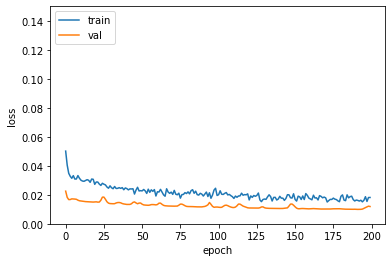

In [71]:
hist = model.fit(x_train, y_train, epochs=200, batch_size=32, validation_data=(x_test, y_test))

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.ylim(0.0, 0.15)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

###  모델 추론

In [43]:
trainScore = model.evaluate(x_train, y_train, verbose=0)
model.reset_states()
print('Train Score: ', trainScore)

testScore = model.evaluate(x_test, y_test, verbose=0)
model.reset_states()
print('Test Score: ', testScore)

Train Score:  0.015112865683753737
Test Score:  0.009980794369570306


### 모델 예측 (1 주)

In [44]:
predictValue = model.predict(currQty.reshape(1,look_back,1))
predictValue[0][0]

0.102218114

### 모델 예측 (연속 주)

In [45]:
qtyIn = list(test.flatten()[-10:])

pred_count = 30 # 최대 예측 개수 정의

pred_out = []

for i in range(pred_count):
    sample_in = np.array(qtyIn)
    currQty = sample_in.reshape(-1,1)
    predValue = model.predict(currQty.reshape(1,look_back,1)).flatten()[0]
    pred_out.append(predValue)
    qtyIn.append(predValue)
    qtyIn.pop(0)

In [46]:
qtyIn = list(train.flatten()[-10:])

pred_count = 37 # 최대 예측 개수 정의

pred_out = []

for i in range(pred_count):
    sample_in = np.array(qtyIn)
    currQty = sample_in.reshape(-1,1)
    predValue = model.predict(currQty.reshape(1,look_back,1)).flatten()[0]
    pred_out.append(predValue)
    qtyIn.append(predValue)
    qtyIn.pop(0)

In [47]:
len(y_test)

37

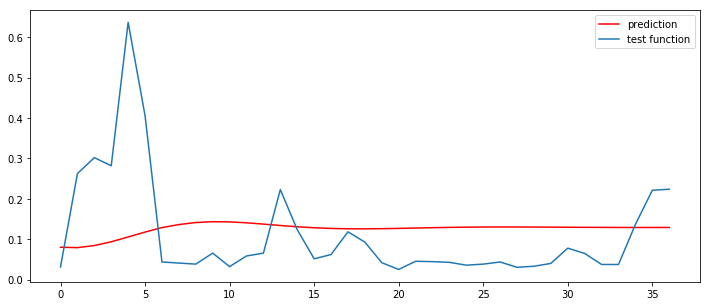

In [48]:
plt.figure(figsize=(12,5))
plt.plot(np.arange(37),pred_out,'r',label="prediction")
plt.plot(np.arange(37),y_test,label="test function")
plt.legend()
plt.show()

## 모델 생성 (상태유지 lstm 신경망)

In [49]:
inputShape

(10, 1)

In [50]:
# 2. 모델 구성하기
model = Sequential()
# batchsize, time_step, shape
model.add(LSTM(32, batch_input_shape=(1, look_back, 1), stateful=True))
model.add(Dropout(0.3))
model.add(Dense(1))

In [51]:
# 3. 모델 학습과정 설정하기
model.compile(loss='mean_squared_error', optimizer='adam')


for i in range(200):
    model.fit(x_train, y_train, epochs=1, batch_size=1, shuffle=False, validation_data=(x_test, y_test))
    model.reset_states()

Train on 97 samples, validate on 37 samples
97/97 [==============================] - 2s 25ms/sample - loss: 0.0328 - val_loss: 0.0147
Train on 97 samples, validate on 37 samples
97/97 [==============================] - 0s 5ms/sample - loss: 0.0299 - val_loss: 0.0139
Train on 97 samples, validate on 37 samples
97/97 [==============================] - 0s 5ms/sample - loss: 0.0299 - val_loss: 0.0132
Train on 97 samples, validate on 37 samples
97/97 [==============================] - 1s 5ms/sample - loss: 0.0251 - val_loss: 0.0126
Train on 97 samples, validate on 37 samples
97/97 [==============================] - 0s 5ms/sample - loss: 0.0215 - val_loss: 0.0123
Train on 97 samples, validate on 37 samples
97/97 [==============================] - 0s 5ms/sample - loss: 0.0219 - val_loss: 0.0119
Train on 97 samples, validate on 37 samples
97/97 [==============================] - 0s 5ms/sample - loss: 0.0243 - val_loss: 0.0128
Train on 97 samples, validate on 37 samples
97/97 [=================

97/97 [==============================] - 0s 5ms/sample - loss: 0.0088 - val_loss: 0.0076
Train on 97 samples, validate on 37 samples
97/97 [==============================] - 1s 6ms/sample - loss: 0.0090 - val_loss: 0.0081
Train on 97 samples, validate on 37 samples
97/97 [==============================] - 0s 5ms/sample - loss: 0.0095 - val_loss: 0.0109
Train on 97 samples, validate on 37 samples
97/97 [==============================] - 1s 8ms/sample - loss: 0.0081 - val_loss: 0.0084
Train on 97 samples, validate on 37 samples
97/97 [==============================] - 1s 6ms/sample - loss: 0.0098 - val_loss: 0.0090
Train on 97 samples, validate on 37 samples
97/97 [==============================] - 1s 5ms/sample - loss: 0.0084 - val_loss: 0.0088
Train on 97 samples, validate on 37 samples
97/97 [==============================] - 1s 7ms/sample - loss: 0.0075 - val_loss: 0.0089
Train on 97 samples, validate on 37 samples
97/97 [==============================] - 1s 5ms/sample - loss: 0.0091

Train on 97 samples, validate on 37 samples
97/97 [==============================] - 1s 5ms/sample - loss: 0.0066 - val_loss: 0.0077
Train on 97 samples, validate on 37 samples
97/97 [==============================] - 1s 5ms/sample - loss: 0.0066 - val_loss: 0.0090
Train on 97 samples, validate on 37 samples
97/97 [==============================] - 0s 5ms/sample - loss: 0.0056 - val_loss: 0.0077
Train on 97 samples, validate on 37 samples
97/97 [==============================] - 0s 5ms/sample - loss: 0.0077 - val_loss: 0.0091
Train on 97 samples, validate on 37 samples
97/97 [==============================] - 1s 5ms/sample - loss: 0.0121 - val_loss: 0.0069
Train on 97 samples, validate on 37 samples
97/97 [==============================] - 0s 5ms/sample - loss: 0.0066 - val_loss: 0.0105
Train on 97 samples, validate on 37 samples
97/97 [==============================] - 1s 8ms/sample - loss: 0.0081 - val_loss: 0.0105
Train on 97 samples, validate on 37 samples
97/97 [==================

In [52]:
trainScore = model.evaluate(x_train, y_train, batch_size=1, verbose=0)
model.reset_states()
print('Train Score: ', trainScore)

testScore = model.evaluate(x_test, y_test, batch_size=1, verbose=0)
model.reset_states()
print('Test Score: ', testScore)


Train Score:  0.005205260266697456
Test Score:  0.01106746381309357


### 1주 예측하기

In [53]:
predictValue = model.predict(currQty.reshape(1,look_back,1))
predictValue[0][0]

0.1344238

In [54]:
qtyIn = list(test.flatten()[-10:])

pred_count = 30 # 최대 예측 개수 정의

pred_out = []

for i in range(pred_count):
    sample_in = np.array(qtyIn)
    currQty = sample_in.reshape(-1,1)
    predValue = model.predict(currQty.reshape(1,look_back,1)).flatten()[0]
    pred_out.append(predValue)
    qtyIn.append(predValue)
    qtyIn.pop(0)